Load All the Initial Python Modules
 - astra_ctvlib is the core component that performs the GPU-tomography reconstuctions

In [1]:
import gpu_3D.Utils.astra_ctvlib as astra_ctvlib
import gpu_3D.Utils.pytvlib as pytvlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import h5py

In [2]:
# Auxilary Function to Visualize Slices of the Phantom Object or Reconstruction
def display_recon_slices(inVolume):

    fig, ax = plt.subplots(1,3,figsize=(25,25))
    ax = ax.flatten()
    ax[0].imshow(inVolume[127,],cmap='gray'); ax[0].axis('off')
    ax[1].imshow(inVolume[:,128,:],cmap='gray'); ax[1].axis('off')
    ax[2].imshow(inVolume[:,:,83],cmap='gray'); ax[2].axis('off')

### Simulating Projections 

Load the Input Dataset (commonly referered to as Tilt Series)

For this demo we'll show how we can use tomo_TV to generate these projections images from an input volume. 

For experimental reconstructions, skip this step and go straight to the reconstruction portion. 

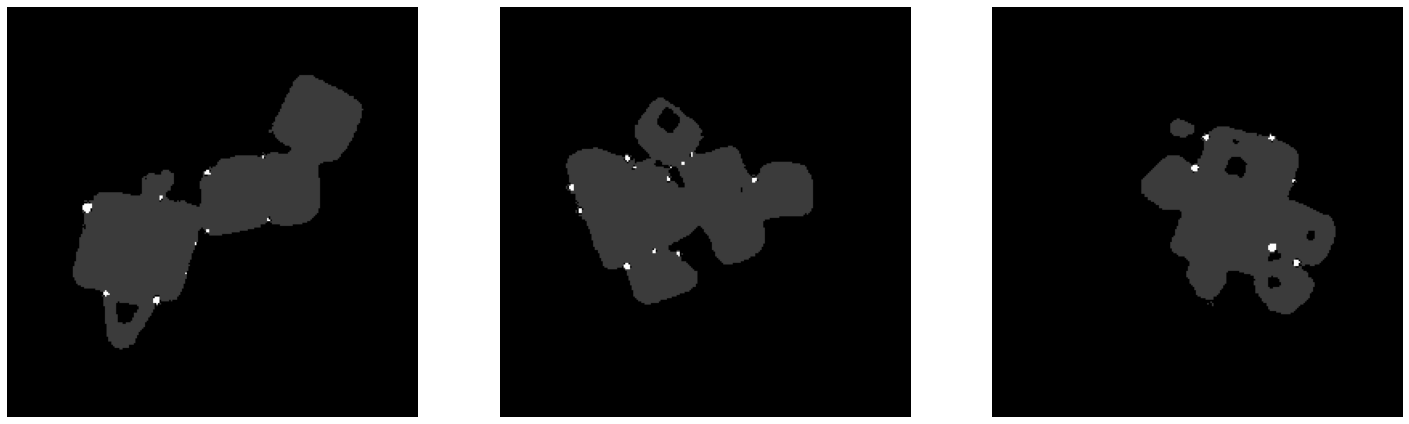

In [3]:
# Load the Original Volume
file = h5py.File('STO_nanocubes.h5','r')
original_volume = file['vol'][:]
file.close()

# Read Dimensions of Test Object
(Nslice, Nray, _) = original_volume.shape
# In cases where projection images aren't square: Nslice != Nray

# Visualize Slices of the Phantom Object
display_recon_slices(np.sqrt(original_volume)) # Rescale to make visualization easier

Before Accessing any of the tomography functionality, we have to initialize the core class and any sub-functions that we would like to interface with.

To inialize this class we need to provide two parameters, 
1. The # of pixels of the projection images / volumes 

2. The tilt angles we would like to simulate the experiment, or angles that projection images were collected. 

In [4]:
# For this demo, we'll use conventional electron tomography experimental parameters: 
# ±70º with a +2º tilt increment. 
tiltAngles = np.arange(-70,72,2) 

# Initialize the C++ Object..
tomo = astra_ctvlib.astra_ctvlib(Nslice, Nray, np.deg2rad(tiltAngles))

# astra_ctvlib by default creates one 3D volume for the reconstruction, 
# any additional volumes needs to be externally intialized 
# (this is to save memory consumption)
tomo.initialize_initial_volume()

### Simulating Projections with a Test Object

<Figure size 1800x1800 with 0 Axes>

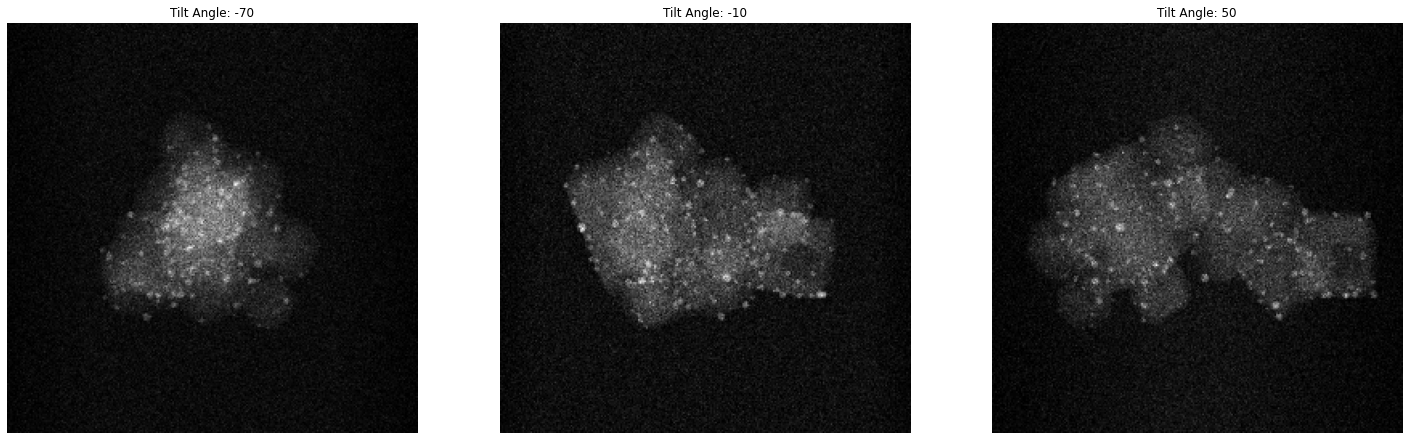

In [5]:
# Optional: Apply Poisson Noise to Background Volume
original_volume[original_volume == 0] = 1

# Let's pass the volume from python to C++  
for s in range(Nslice):
    tomo.set_original_volume(original_volume[s,:,:],s)

# Now Let's Create the Projection Images
tomo.create_projections()

# Optional: Apply poisson noise to volume.
SNR = 5
if SNR != 0: tomo.poisson_noise(SNR)

# Return the projections to Python
Nangles = tiltAngles.shape[0]
tiltSeries = np.zeros([Nslice, Nray, Nangles],dtype=np.float32)
projections = tomo.get_projections()

for i in range(Nangles):
    tiltSeries[:,:,i] = projections[:,Nray*i:Nray*(i+1)]

# Visualize Tilt Series
plt.figure(figsize=(25,25))
fig, ax = plt.subplots(1,3,figsize=(25,25))
ax = ax.flatten()
for j in range(3): 
    ax[j].imshow(tiltSeries[:,:,j*30],cmap='gray'); 
    ax[j].axis('off'); 
    ax[j].set_title('Tilt Angle: ' + str(tiltAngles[j*30]))

In [7]:
file = h5py.File('au_sto_tilt_series.h5','w')
file.create_dataset('tiltSeries',data=tiltSeries)
file.create_dataset('tiltAngles',data=tiltAngles)
file.close()

### Passing Experimental Projections into tomo_TV

Refer to the following cell to pass experimental projections to tomo_TV. 

We assume the tilt-axis is along the second dimension. 

In [3]:
file = h5py.File('au_sto_tilt_series.h5','r')
tiltSeries = file['tiltSeries'][:]
tiltAngles = file['tiltAngles'][:]
file.close()

# The dimensions for these variables are::
# tiltSeries.shape = (Nslice, Nray, Nangles)
# tiltAngles.shape = (Nangles,)

# Create Projections Vector
(Nslice, Nray, Nangles) = tiltSeries.shape

# Initialize the C++ Object..
tomo = astra_ctvlib.astra_ctvlib(Nslice, Nray, np.deg2rad(tiltAngles))

b = np.zeros([Nslice, Nray*Nangles])
for s in range(Nslice):
    b[s,:] = tiltSeries[s,:,:].transpose().ravel()
    
# Pass the Tilt Series to tomo_TV C++ object.
tomo.set_tilt_series(b)

### Tomography Recontructions

Now that we have a sample tilt series, let's actually reconstruct the data and see how it compares to the ground truth

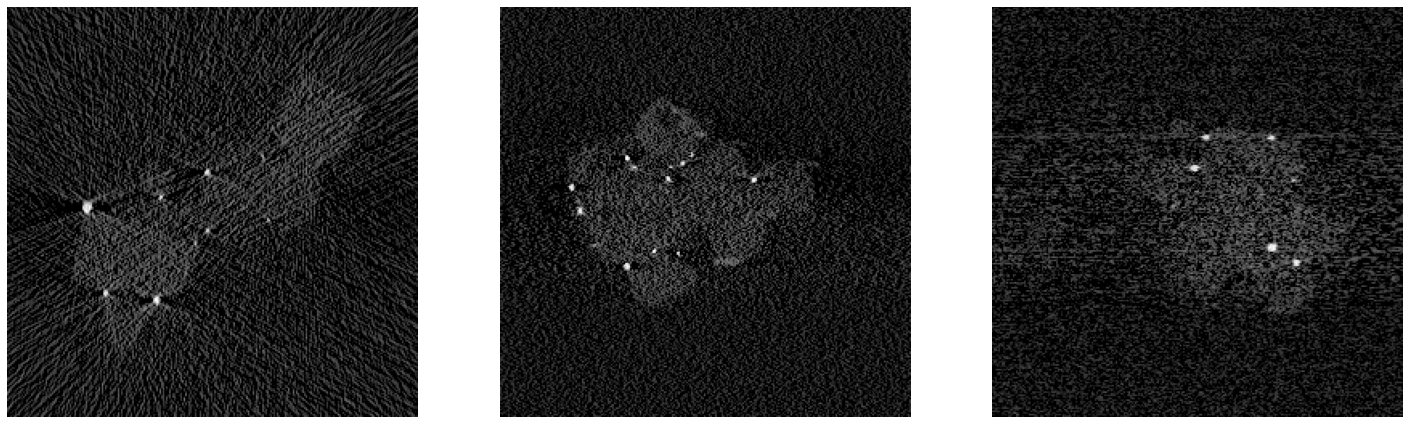

In [4]:
# We have quite a few algorithms to choose from, for simplicitiy let's start off with FBP

# Start off by initializing the FBP reconstruction operator
alg = 'FBP'; filter = 'ram-lak'    
pytvlib.initialize_algorithm(tomo,alg,filter)
# other filter options include: 
# none, ram-lak, shepp-logan, cosine, hamming, hann, tukey, lanczos,
# triangular, gaussian, barlett-hann, blackman, nuttall, blackman-harris,
# blackman-nuttall, flat-top, kaiser, parzen

# Reconstruct the Data
pytvlib.run(tomo,alg)

# Return the Reconstruction to Python
recon = np.zeros([Nslice,Nray,Nray],dtype=np.float32)
for s in range(Nslice):
    recon[s,] = tomo.get_recon(s)
    
# Visualize Slices of the Phantom Object
display_recon_slices(np.sqrt(recon))

Oof, as expected FBP is terrible. Let's now try an iterative algorithm like SIRT. 

100%|██████████| 150/150 [00:17<00:00,  8.35it/s]


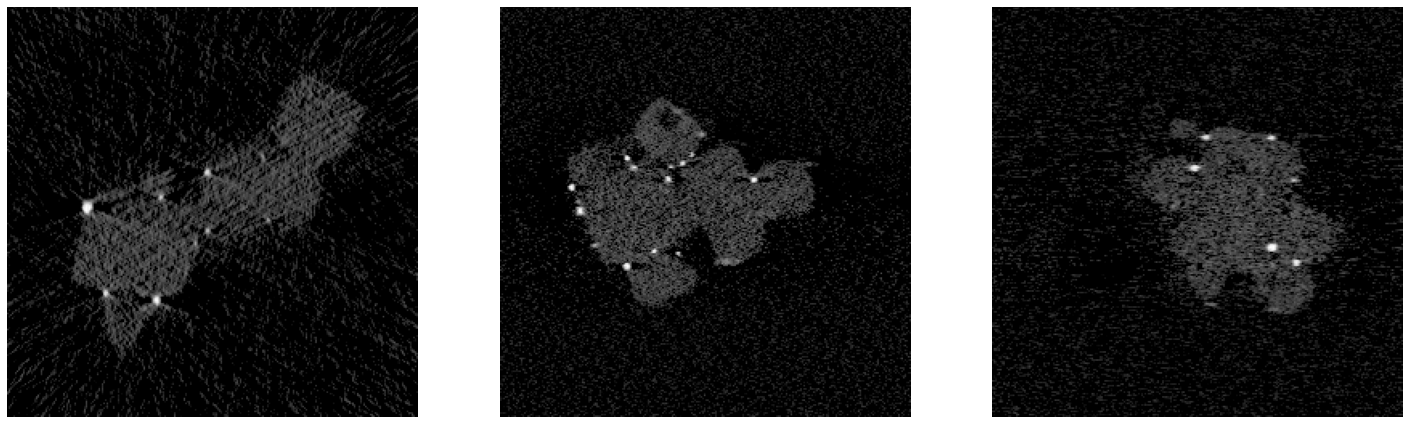

In [6]:
# Start with a fresh reconstruction by setting all the values to zero. 
tomo.restart_recon()

# Start off by initializing the SIRT reconstruction operator
alg = 'SIRT'
pytvlib.initialize_algorithm(tomo,alg)

# Main Loop
Niter = 150
for i in tqdm(range(Niter)):
    pytvlib.run(tomo,alg)
    
# Return the Reconstruction to Python
recon = np.zeros([Nslice,Nray,Nray],dtype=np.float32)
for s in range(Nslice):
    recon[s,] = tomo.get_recon(s)
    
# Visualize Slices of the Phantom Object
display_recon_slices(np.sqrt(recon))

We also have the freedom to try other algorithms like Conjugate Gradient Least Squares (CGLS) or Simultaneous Algebraic Reconstruction Technique (SART).

100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


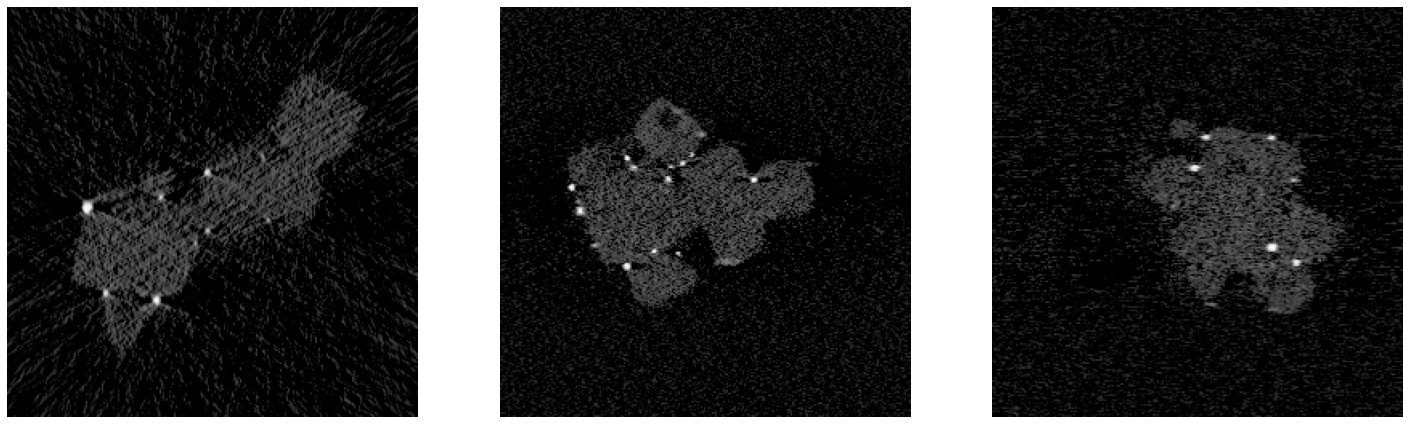

In [14]:
# Start with a fresh reconstruction by setting all the values to zero. 
tomo.restart_recon()

# Start off by initializing the CGLS reconstruction operator
alg = 'CGLS'
pytvlib.initialize_algorithm(tomo,alg)

Niter = 50
for i in tqdm(range(Niter)):
    pytvlib.run(tomo,alg)
    
# Return the Reconstruction to Python
recon = np.zeros([Nslice,Nray,Nray],dtype=np.float32)
for s in range(Nslice):
    recon[s,] = tomo.get_recon(s)
    
# Visualize Slices of the Phantom Object
display_recon_slices(np.sqrt(recon))

SIRT and other varients like Conjugate Gradient Method (CGLS) all minimize the following least squares problem: $ \arg \min_x \frac{1}{2} \|Ax - b\|_2^2 $ which assumes the noise is Gaussian. 

In cases where we actually Poisson limited (e.g. spectral maps) we actually prefer to use the KL-Divergence or Maximum Likelihood (ML): $ \arg \min_x \sum Ax - b \log(Ax - \epsilon) $. <br/>

100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


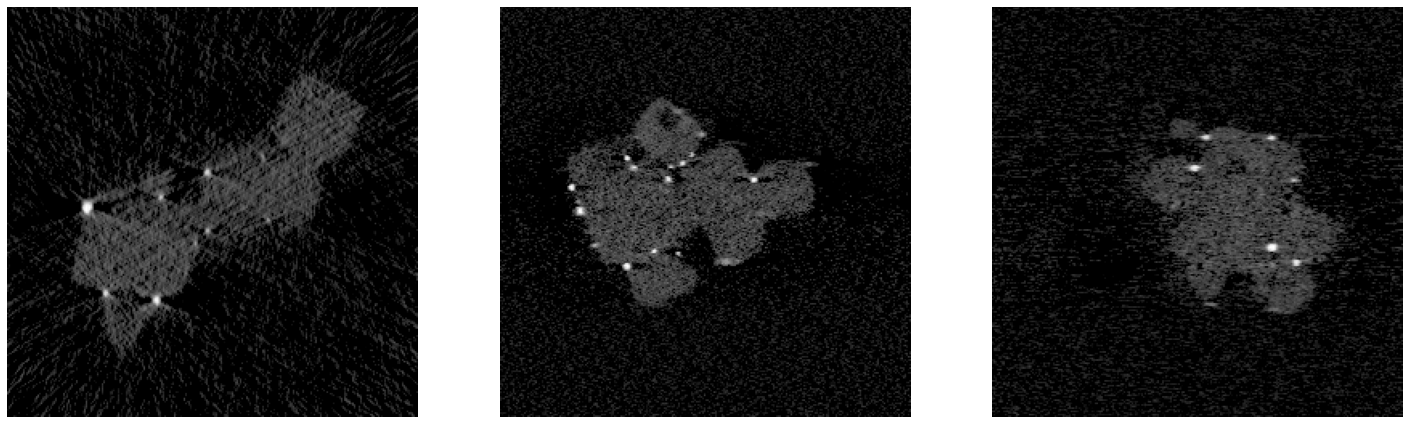

In [4]:
# Start with a fresh reconstruction by setting all the values to zero. 
tomo.restart_recon()

# Start off by initializing the Maximum Likelihood reconstruction operator
alg = 'kl-divergence' # could also pass in poisson_ML as algorithm name
pytvlib.initialize_algorithm(tomo,alg)

Niter = 100; step_size = 0.1
for i in tqdm(range(Niter)):
    pytvlib.run(tomo,alg,step_size)
    
# Return the Reconstruction to Python
recon = np.zeros([Nslice,Nray,Nray],dtype=np.float32)
for s in range(Nslice):
    recon[s,] = tomo.get_recon(s)
    
# Visualize Slices of the Phantom Object
display_recon_slices(np.sqrt(recon))

We can also try more advanced compressed sensing algorithms that incorporate regularization into popular unconstrained optimization problem:

$$ \arg \min_{x} \| Ax - b \|_2^2 + \lambda \| x\|_{TV} $$

This classs of inverse problems has gained in popularity through its capability to guarantee near-perfect signal recovery with $L_1$ minimization. Specifically, we're aiming to minimize our volume's total variation. 

100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Text(0, 0.5, 'Objective Function')

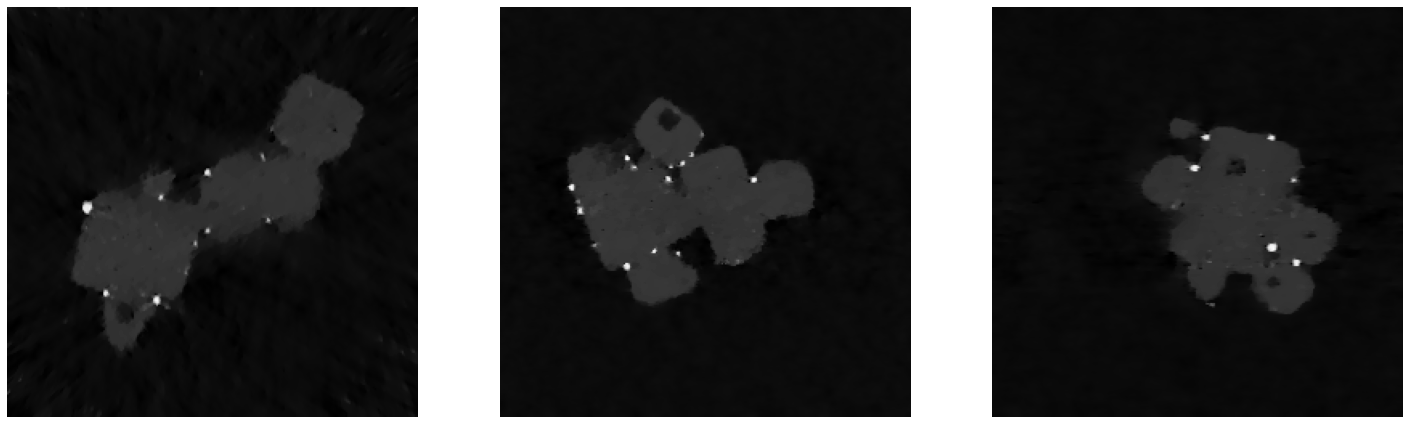

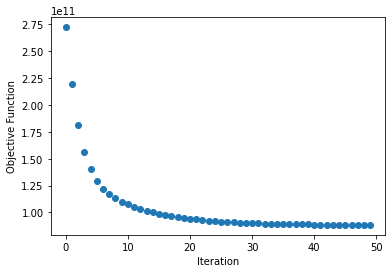

In [13]:
tomo.restart_recon()

# Inialize the Reconstruction Algorithm
alg = 'fista'; momentum = True
pytvlib.initialize_algorithm(tomo,alg)

# Ignore Momentum Acceleration
if not momentum: tomo.remove_momentum()

# Reconstruction Parameters
Niter = 50; lambdaParam = 0.1; nTViter = 10

# Momentum and Objective Function 
cost = np.zeros(Niter); t0 = 1

# Main Loop 
for k in tqdm(range(Niter)):
    # Gradient Step
    pytvlib.run(tomo,alg)
    
    # Threshold Step
    tomo.tv_fgp(nTViter,lambdaParam)
    
    # Momentum Step
    if momentum: 
        tk = 0.5 * (1 + np.sqrt(1 + 4 * t0**2))
        tomo.fista_momentum((t0-1)/tk)
        t0 = tk

    # Measure Objective  
    cost[k] = 0.5 * tomo.data_distance()**2 + lambdaParam * tomo.tv()

# Return the Reconstruction to Python
recon = np.zeros([Nslice,Nray,Nray],dtype=np.float32)
for s in range(Nslice):
    recon[s,] = tomo.get_recon(s)
    
# Visualize Slices of the Phantom Object
display_recon_slices(np.sqrt(recon))

# View the Objective Function
plt.figure()
plt.scatter(np.arange(Niter),cost); plt.xlabel('Iteration'); plt.ylabel('Objective Function')

Now let's solve the constrained formulation of compressed sensing with Adpative Steepest Descent - Projection onto Convex Sets (ASD-POCS):

$$ \arg \min_{x} \| x\|_{TV} \text{~s.t.~} \| Ax - b \|_2^2 < \varepsilon $$

Unlike the unconstrained formulation solved with FISTA, ASD-POCS bounds our solution within a subset of the solution space, defined by the user input parameter $\varepsilon$,

In [ ]:
# Start with a fresh reconstruction by setting all the values to zero. 
tomo.restart_recon()

# Algorithm
alg = 'ASD-POCS'; 
# SART Algorithm Parameters (Projection Order - {'random', or 'sequential'})
initAlg = 'sequential' 
pytvlib.initialize_algorithm(tomo,alg)

# Number of Iterations (Main Loop)
Niter = 100

# Data Tolerance Parameter
eps = 0.025

# Descent Parameter and Reduction
beta0, beta_red = 0.25, 0.9985

# Reduction Criteria
r_max = 0.95    ; nTViter = 10
alpha_red = 0.95; alpha = 0.2

#####################################################

#Main Loop
beta = beta0
dd_vec, tv_vec = np.zeros(Niter), np.zeros(Niter)
for i in tqdm(range(Niter)): 
    
    tomo.copy_recon() 

    pytvlib.run(tomo, alg, beta) # Reconstruction
    beta *= beta_red # Beta Reduction

    # Measure Magnitude for TV - GD
    if (i == 0):
        dPOCS = tomo.matrix_2norm() * alpha
        dp = dPOCS / alpha
    else:
        dp = tomo.matrix_2norm()

    # Measure difference between exp / sim projections. 
    dd_vec[i] = tomo.data_distance()

    tomo.copy_recon()

    # TV Minimization
    tv_vec[i] = tomo.tv_gd(nTViter, dPOCS)
    dg = tomo.matrix_2norm()

    if (dg > dp * r_max and dd_vec[i] > eps):
        dPOCS *= alpha_red


Wow! So much better. We can also add regularization and try clean up the reconstructions further

In [ ]:
# Number of TV Iterations
nTViter = 25

# Lambda Parameter
tvLambda = 15

# This is the Fast Gradient Projection Method for Solving TV Denoising
tomo.tv_fgp(nTViter, tvLambda)

for s in range(Nslice):
    recon[s,] = tomo.get_recon(s)
    
# Visualize Slices of the Phantom Object
display_recon_slices(np.sqrt(recon))